# HeartDiseaseAna44

## Supervised Machine Learning Pipeline Example: Heart Disease classification using tree-based methods

Joanne Leung (BSMD) <br>
February 23, 2018 <br>

## Overview

HeartDiseaseAna44 is is an implementation of a supervised machine learning workflow template executable on Network A.  Its purpose is to faciliate learning and experimentation with machine learning tools available in Python for Statistics Canada colleagues who are new to machine learning or Python. <br>

HeartDiseaseAna44 is a fully automated pipeline.  The pipeline can be broken down into various steps:
 - Data exploration
 - Splitting into training and test sets
 - Data pre-processing
 - Training and model selection
 - Performance evaluation on the test set

The purpose of this Jupyter notebook is to give some brief explanations of what the pipeline does. In this notebook, you will get a taste of some functionalities of several Python packages that are widely used in the machine learning community, including but not limited to: 
- `NumPy` (array processing)
- `Pandas` (data analysis)
- `Matplotlib` (data visualization)
- `Seaborn` (data visualization)
- `Scikit-learn` (machine learning tools)

These Python packages are already included in the Anaconda installation (version 4.4 or above) on Network A.   

The programs presented here are only intended to work well for this specific Heart Disease data set.  We will go through the main program in this notebook.  In addition to the main program, selected functions that we built in the custom modules will be presented here to highlight some important functionalities in the process flow.  We encourage you to go directly to the source code `*.py` files if you would like to get a deeper understanding or to adapt parts of the code and try it with your own data.  You will learn from this pipeline how to program things such as creating histograms and bar charts, model fitting and predictions in a supervised machine learning setting, model evaluation and comparison using various metrics, and even exporting the data into an Excel file!  

Please keep in mind that this notebook is not intended to teach Python or machine learning from scratch.  To gain better understanding of machine learning or the programming language Python, please consult the references cited in the "Learning material" section in the `README.txt` file.

## Set up the environment

First we import some required Python libraries.

In [1]:
import os, sys, shutil, getpass
import pprint, logging, datetime
import stat

import numpy   as np
import pandas  as pd

Next, we define/determine the location of the code and data directories within HeartDiseaseAna44. The code directory contains a number of custom-built Python modules for HeartDiseaseAna44. The purpose of these toy Python modules is to demonstrate how to use Python modules in general, as well as how they can be used to keep our Python code clean and uncluttered.

In [2]:
dir_MASTER = ".."
dir_code   = os.path.join(dir_MASTER, "code")
dir_data   = os.path.join(dir_MASTER, "data")

A little sanity check: print the contents of the data directory, to make sure that Python can indeed properly access the code directory.

In [3]:
# check dir_code has been set correctly
print(os.listdir(dir_code))

['HD_preprocessing.py', 'HD_model_comparisons.py', 'HD_model_evaluation.py', '__init__.py', 'HD_pipeline_preprocess.py']


We need to add the code directory to the system path, so that we can import the custom-built modules and be able to access the all the functions programmed for this pipeline a little later on. 

In [4]:
sys.path.append(dir_code)

## Heart Disease data

The Heart Disease data set consists of heart disease diagnosis of 303 patients collected by the Cleveland Clinic Foundation.  The data set can be obtained from the University of California at Irvine (UCI) Machine Learning Repository: https://archive.ics.uci.edu/ml/datasets/Heart+Disease.  For a detailed description of the variables, please consult the website above or refer to the header in the `HD_MASTER.py` program.

Before we run any of the machine learning algorithms, we first set the value of the seed of the random state so that the results of this pipeline can be replicable.

In [5]:
seed = 274

Since we are running this pipeline in the Jupyter environment, all the plots will be shown inline within this document.  There is no need to save the plots into PNG files.  In order to distinguish this important difference, we create a variable called `save_plots`.  Here, in this notebook, we set it to `False`.  When we execute the actual main program `HD_MASTER.py`, we run the whole pipeline in the command prompt in one shot. We will save all the plots there, thus the variable will be set as `True`.  

In [6]:
save_plots = False

Next, we choose a scoring method to use when we perform cross validation.  In binary classification, we evaluate the performance of the models using some metrics derived based on the confusion matrix.  It is important to choose a good measure that fits the nature of your research problem.  It is also important to note that some measures do not work well when the target class is imbalanced.  Common scoring methods in classification problems include accuracy, F1-score precision, recall/sensitivity, specificity, area under the receiver operating characateristic (ROC) curve, Matthews correlation coefficient etc.  

In medical classification problems, sensitivity and specificity are often the preferred measures.  
- Sensitivity is the true positive rate.  It refers to the extent to which true positives are not missed. We would prefer a highly sensitive test because we do not want to miss anyone who has a life-threatening condition. 
- Specificity is the true negative rate.  It is the extent to which the true negatives are correctly classified.  We would prefer a test that is highly specific because we do not want someone to undergo any unnecessary treatments.

There’s a trade-off between sensitivity and specificity.  Depending on the goal of the research problem, we might want to maximize one or the other, or we could also look at a combination of both using the ROC curve.  

In tree-based binary classification, each prediction is associated with a class probability.  The default threshold is 0.5: When the probability of a case in the training set or in the test set is greater than 0.5, the unit is predicted as Class 1, otherwise it will be in Class 0.  When the threshold changes, the predicted classes also change, and so a different confusion matrix can be constructed.  The ROC curve is a graphical representation of sensitivity (true positive rate) versus 1-specificity (false negative rate) at various threshold settings.  

The ROC curve can also be summarized into one number as the area under the curve (AUC), and this is a common metric to measure performance.  We will use it when we do cross validation.  A perfect classifier has an area of 1 and a random classifier has an area of 0.5.

In [7]:
cv_scoring_method = "roc_auc"
cv_scoring_name = "roc_auc"

It is also possible to feed a user-defined metric, or to use more than one metric in cross validation (`scikit-learn` version 0.19+).  For details, please consult the `scikit-learn` User Guide on www.scikit-learn.org.

## Step 1: Data exploration

Before we read in the Heart Disease data set, we need to import a function from the custom-built Python module `HD_preprocessing.py`: `read_heart_file`.  To gain a deeper insight on what these function does, please refer to the `HD_preprocessing.py` file in the `code` folder.

In [8]:
from HD_preprocessing import read_heart_file

We are now ready to read the input file from the data directory.  We will read the file into a `pandas` "data frame", which looks like a SAS data set, or an Excel spreadsheet, with rows numbered and with variable names labelled at the top of each column.

In [9]:
heart_FILE = os.path.join(dir_data, 'processed.cleveland.data')
heart_disease = read_heart_file(heart_FILE)

The steps to examine the Heart Disease data set are in the `examine_heart_data` function in `HD_preprocessing.py`.  Instead of calling this function, we will go through it step by step in this notebook.  

Let's have a first look at the dimension of the data set.  The first number refers to the number of rows and the second number is the number of columns.  Therefore, the Heart Disease file contains 303 rows and 14 columns, i.e., 303 observations and 14 variables.

In [10]:
heart_disease.shape

(303, 14)

The `info()` function in pandas provides basic information of the variable names and types in the data set, just like `PROC CONTENTS` in SAS.  There seems to be no null values observed in the data, which is good.  However, the `coloured_vessels` and `thal` columns are of "object" type.  We will soon take a closer look at them.  

The `presence` variable, which is the target variable in this pipeline, is of boolean type.  It has a value of `True` (1) or `False` (0).  Cases of True mean heart disease is likely to be present, and False otherwise.

In [11]:
heart_disease.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
age                    303 non-null float64
sex                    303 non-null float64
chest_pain_type        303 non-null float64
rest_bp                303 non-null float64
cholesterol            303 non-null float64
fast_blood_sugar       303 non-null float64
rest_ecg               303 non-null float64
max_hr_achieved        303 non-null float64
exer_induced_angina    303 non-null float64
old_peak               303 non-null float64
slope                  303 non-null float64
coloured_vessels       303 non-null object
thal                   303 non-null object
presence               303 non-null bool
dtypes: bool(1), float64(11), object(2)
memory usage: 31.1+ KB


The `head()` and the `tail()` functions within the `pandas` package allow us to look at the first five and last five rows of the data.  Note that in Python, the index of the first row/column of any array or data frame is 0, as seen below.  We see that in the last row (303rd record, row 302), the value of `coloured_vessels` is "?".  We take note of it and will look for ways to deal with it during data pre-processing.

In [12]:
heart_disease.head()

,age,sex,chest_pain_type,rest_bp,cholesterol,fast_blood_sugar,rest_ecg,max_hr_achieved,exer_induced_angina,old_peak,slope,coloured_vessels,thal,presence
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,False
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,True
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,True
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,False
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,False


In [13]:
heart_disease.tail()

,age,sex,chest_pain_type,rest_bp,cholesterol,fast_blood_sugar,rest_ecg,max_hr_achieved,exer_induced_angina,old_peak,slope,coloured_vessels,thal,presence
298,45.0,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,2.0,0.0,7.0,True
299,68.0,1.0,4.0,144.0,193.0,1.0,0.0,141.0,0.0,3.4,2.0,2.0,7.0,True
300,57.0,1.0,4.0,130.0,131.0,0.0,0.0,115.0,1.0,1.2,2.0,1.0,7.0,True
301,57.0,0.0,2.0,130.0,236.0,0.0,2.0,174.0,0.0,0.0,2.0,1.0,3.0,True
302,38.0,1.0,3.0,138.0,175.0,0.0,0.0,173.0,0.0,0.0,1.0,?,3.0,False


Similar to `PROC MEANS` in SAS, the `describe()` function in the `pandas` package produces some descriptive statistics for the numeric variables.  Since the variables `coloured_vessels` and `thal` are not considered numeric, they do not appear in the results.

In [14]:
heart_disease.describe()

,age,sex,chest_pain_type,rest_bp,cholesterol,fast_blood_sugar,rest_ecg,max_hr_achieved,exer_induced_angina,old_peak,slope
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.438944,0.679868,3.158416,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,1.600660
std,9.038662,0.467299,0.960126,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000
50%,56.000000,1.000000,3.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000


We can do some basic counts for variables in a data frame.  For example, we would like to look at what is in the target variable `presence`.  There are various ways to filter a data frame by columns.  One easy way is to put the column name within square brackets.  For example, `heart_disease["presence"]` refers to the `presence` column in the `heart_disease` data set.  To generate counts of a column in the data frame, we can use the `value_counts()` function.

In [15]:
heart_disease["presence"].value_counts()

False    164
True     139
Name: presence, dtype: int64

We see that the two target classes are quite balanced, with about 55% in Class 0 (`False`) and 45% in Class 1 (`True`).

## Step 2: Split the data into training and test sets

We are now ready to split the data set into a training set and a test set.  Before doing so, we separate the dependent variable, `presence`, from the rest of the variables.  The `X` data set contains all the independent variables (which are often known as "features" in machine learning literature).  The `y` data set contains only the dependent variable (also called "target").  

An advantage of using the `pandas` data frame is that data subsetting can be done by providing the column names, which is often more intuitive than giving the row or column numbers, although both methods work fine.

In [16]:
# Split into features (or X, independent variables, predictors) and targets (or y, classes, dependent variable)
X = heart_disease.drop(["presence"], axis=1)
y = heart_disease["presence"].copy()

Both the `X` and the `y` variables need to be split into training and test sets.  Here, we built a custom function called  `split_dataset()`, which internally calls the `train_test_split()` function from the `model_selection` module in `scikit-learn`.  The `split_dataset` function is presented (as comments) below.  Note that in Python a function is defined using the def keyword, and all the steps within the function are indented.

Note that the `train_test_split()` function is quite flexible.  We are only calling it in a very specific way.  Our function call works as follows: We take a random sample of `X`, stratified by the value in `y`.  In the Heart Disease example, we set the sampling rate for the test set as 30%, which means that the training set will contain the remaining 70% of the data.

For verification purposes, we also printed the distribution of the classes before and after the split.  In the code below, we use the `pd.concat()` function in `pandas` to concatenate two data sets.  When `axis` is set to 1 (columns), this is similar to a `merge` in SAS.  When `axis` is set to 0 (rows), this is similar to a putting multiple data sets in a `set` statement in the `DATA` step.

In [17]:
from HD_preprocessing import split_dataset

#def split_dataset(X, y, stratify, test_size, random_state):
#    """
#    Splits the data into training and test sets according to test_size.
#    The split is stratified by the "stratify" variable.
#    """
#    X_train, X_test, y_train, y_test = train_test_split(X, y, 
#                                                        test_size = test_size, 
#                                                        stratify = stratify,
#                                                        random_state = random_state)
#
#    print("\nSplitting the data into training set and test set...")
#    print("Number of records in the full data set: {}".format(X.shape[0]))
#    print("Number of records in the training set: {}".format(X_train.shape[0]))
#    print("Number of records in the test set: {}".format(X_test.shape[0]))
#
#
#    # verification
#    full_X = pd.concat((X_train, X_test), axis=0)
#    full_y = pd.concat((y_train, y_test), axis=0)
#    full = pd.concat((full_X, full_y), axis=1)
#    
#    training = pd.concat((X_train, y_train), axis=1)
#    test = pd.concat((X_test, y_test), axis=1)
#    
#    print("\nClass distribution in full data set:")
#    print(   full.groupby("presence").size() )
#
#    print("\nClass distribution in training set:")
#    print(   training.groupby("presence").size() )
#
#    print("\nClass distribution in test set:")
#    print(   test.groupby("presence").size() )
#
#    return X_train, X_test, y_train, y_test

# Split the data into training and test sets
X_train, X_test, y_train, y_test = split_dataset(X, y, stratify=y, test_size=0.3, random_state=seed)


Splitting the data into training set and test set...
Number of records in the full data set: 303
Number of records in the training set: 212
Number of records in the test set: 91

Class distribution in full data set:
presence
False    164
True     139
dtype: int64

Class distribution in training set:
presence
False    115
True      97
dtype: int64

Class distribution in test set:
presence
False    49
True     42
dtype: int64


## Step 3: Data pre-processing

### Visualization of the training set

Before we pre-process the data, let's first visualize the training set.  Instead of calling the custom-built `visualize_heart_data` function in `HD_preprocessing.py` directly, we will go through it step by step here.

In [18]:
# Combine the features and target to form the complete training data
training_set = pd.concat((X_train, y_train), axis=1)

From the description of the data set on the UCI Machine Learning Repository's website, we know that some data are considered categorical.  We need to identify them before looking at their distributions.

In [19]:
# continuous variables
cts_vars = ["age", "rest_bp", "cholesterol", 
            "max_hr_achieved", "old_peak"]

# categorical variables
cat_vars = ["sex", "chest_pain_type", "fast_blood_sugar", 
            "rest_ecg", "exer_induced_angina", "slope", 
            "coloured_vessels", "thal", "presence"]

The `matplotlib` and `seaborn` packages are required to produce the plots in this pipeline.

For continuous variables, we will produce some histograms.  We see that some of the variables are skewed.  The variables are also in different ranges.  This is not an issue for tree-based methods, but if you would like to try other machine learning algorithms, feature scaling using standardization or normalization will sometimes be required.

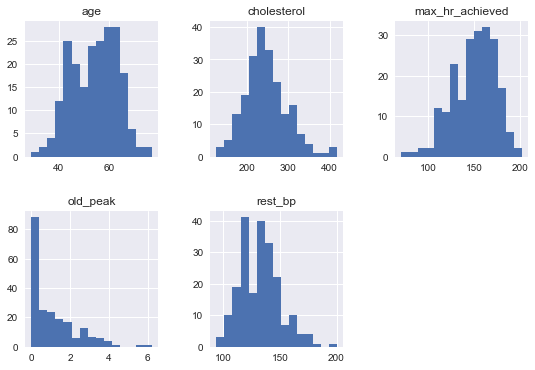

In [20]:
import matplotlib.pyplot as plt
training_set[cts_vars].hist(bins = 15, figsize = (9, 6), layout=(2, 3))
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()

For categorical variables, we will produce bar charts to look at the counts.  To save space we put all bar charts on the same figure, with three bar charts per row.  The indices `i` and `j` in the code below indicate the location (row and column) of the subplot for a given plot.  Note that Python relies solely on indentation to identify blocks within if-else conditions and within loops.

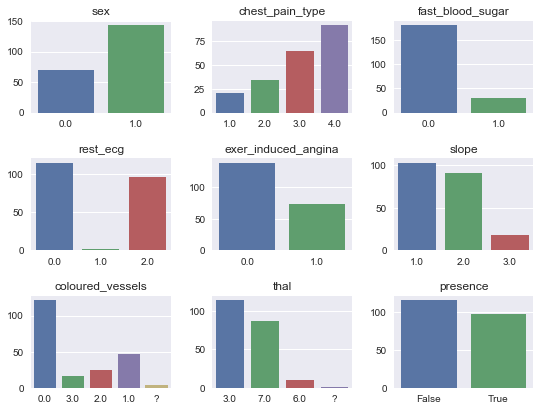

In [21]:
import math
import seaborn as sns

ncols = 3
nrows = int(math.ceil(len(cat_vars)/ncols))
    
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3*ncols, 2.25*nrows))

i = 0
j = 0
for var in cat_vars:
    sns.countplot(x=var, data=training_set, ax=ax[i][j])
    ax[i][j].set_title(var)
    ax[i][j].set_xlabel("")
    ax[i][j].set_ylabel("")
    j += 1
    if j == 3:
        j = 0
        i += 1
    
plt.subplots_adjust(wspace=0.3, hspace=0.5)
plt.show()

According to the data set descriptions on the UCI's website, for `thal`, it has three possible values: 3 = normal; 6 = fixed defect; 7 = reversable defect.  However, we found a "?", which is probably an indicator for missing value.  For `coloured_vessels`, we also see cases with "?" in the data set.  There are different ways to treat these "?".  We could remove the observations, or treat them as a standalone category, or impute them.  We will use a basic strategy to impute them later on so that the data set we use in training and in testing will not contain any missing values.

We can also see the distribution of the two classes in the target variable, `presence`, is relatively balanced.  Care would need to be taken in the choice of evaluation metrics if the two classes are highly imblanced (e.g. 95% in class 0 and 5% in class 1), as a dummy classifer that always returns a prediction of 0 can achieve an accuracy of 95%.

Next, we look at the pairwise relationships among any two numeric variables and the target variable, by means of a pair plot.  From these plots, there does not seem to be anything that is of immmediate concern.  And it does not look like we can pick any two numeric variables alone and come out with a rule to classify the units.

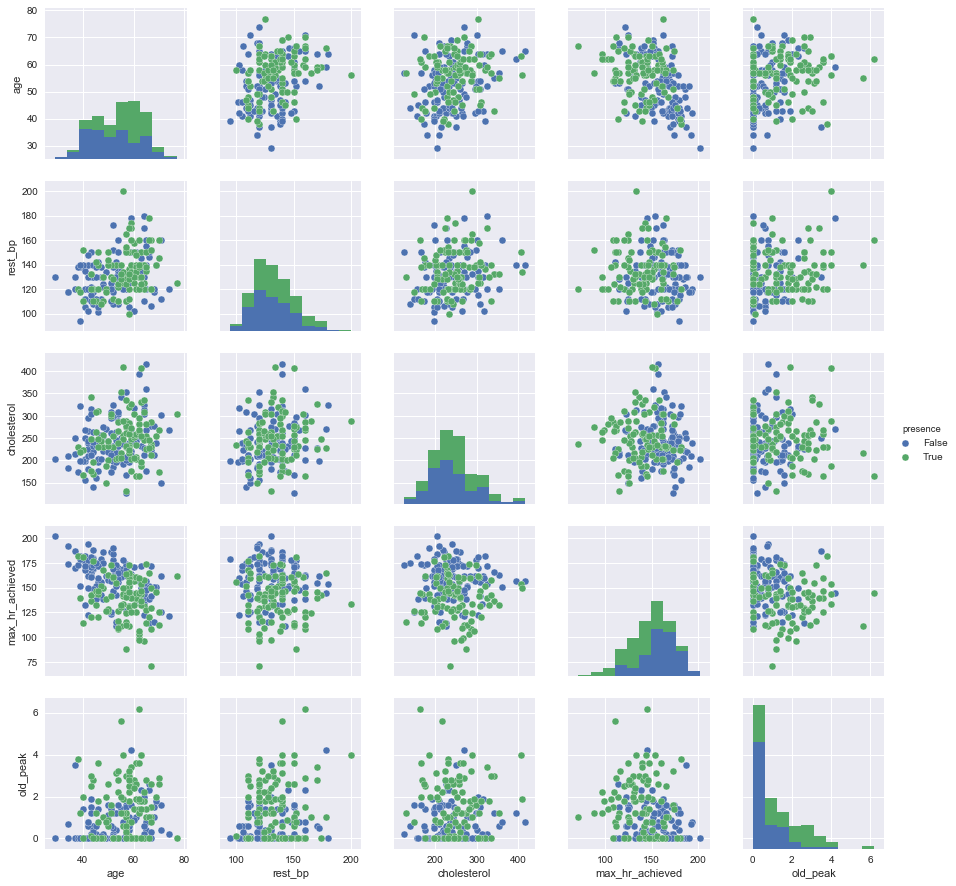

In [22]:
sns.pairplot(data=training_set, vars=cts_vars, hue="presence")
plt.show()

We can plot the correlation matrix, and present it as a heat map usnig a colour palette of our choice.  Since the matrix is symmetrical and that the diagnonals are all 1, we will only look at the cells below the diagonals.  Again, there does not seem to show any immediate concerns.

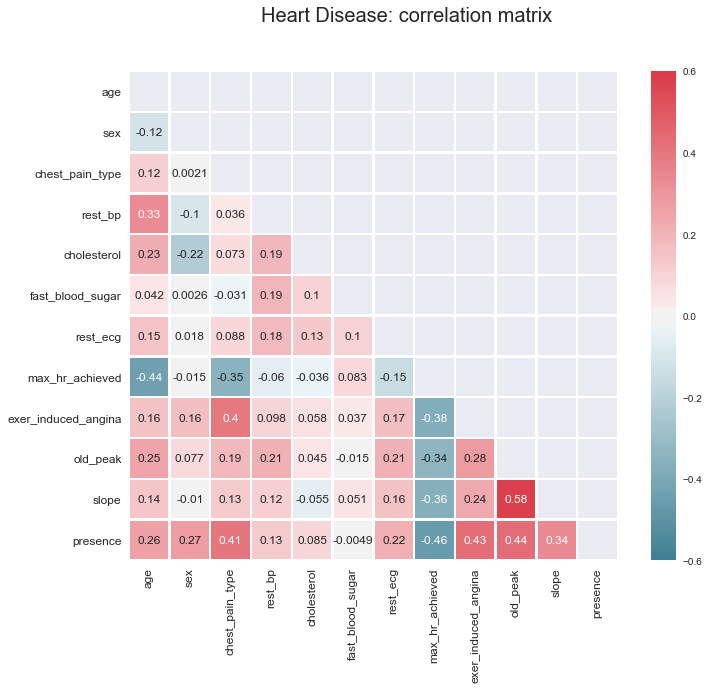

In [23]:
corr = training_set.corr()

# Plot the correlation matrix
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 9))
fig.suptitle("Heart Disease: correlation matrix", fontsize=20)
    
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
    
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
    
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=0.6, center=0, 
            square=True, annot=True, linewidths=1.5, ax=ax)

plt.yticks(rotation=0, fontsize=12)
plt.xticks(rotation="vertical", fontsize=12)
plt.show()

### Setting up the Strategy for Data Pre-processing

In order for machine learning algorithms to run without crashing and provide meaningful results, it is not unusual to spend most of our time to pre-process the data.  Typical procedures can include imputation of missing values, coding of categorical data, outlier detection and treatment, feature extraction and feature scaling.  It is crucial to have the test set to <b>not</b> influence the training set.  Missing data are imputed after the full data set is split into training and test sets.  Imputation methods, such as the mean or the median, are first applied on the training set to determine the imputed values.  These same imputed values are used to replace missing values found on the test set.

For our Heart Disease example, much of this work has already been done by researchers.  Feature extraction had already been done in the Cleveland data: the data set we downloaded contains only 14 variables out of 76 from the original data.  Also, categorical data had already been encoded into numeric values, except for a few missing values.  As for feature scaling, since we are going to use tree-based methods, we do not need to worry about it.  So the amount of pre-processing that still needs to be done is minimal.  

Our pre-processing step consists of two parts:

 1. <b>Imputation of missing values</b>
<br>There is a built-in object called `Imputer` in `scikit-learn` that can do basic imputation on numeric values using the mean, median or the most frequent value.  This does not work, however, when the variable is of  `object` type.  So, in our case, we need to first replace the "?" into `NaN` (<u>N</u>ot <u>a</u> <u>N</u>umber), just like `.` in SAS, then change the data type from `object` back to `float`, before using the `Imputer` to impute by the mode. <br><br>

 2. <b>Creation of dummy varibles for nominal categorical variables</b>
<br>In general, tree-based methods allow a mix of numeric and categorical variables in the features.  However, in `scikit-learn`, all the data sets that goes into the machine learning models need to be of numeric type.  That means decision rules in a tree would always look like "if `variable` <= `value`".  This is not a problem if the categorical variables are ordinal in nature, e.g., `fast_blood_sugar` is 1 when fasting blood sugar is <= 120mg/dl, and is 0 when it is > 120mg/dl.  However, for variables that are nominal in nature, it is unclear whether one category is inferior than another.  For instance, `chest_pain_type` is divided into four categories: 1 = typical angina; 2 = atypical angina; 3 = non-anginal pain; 4 = asympotmatic. To deal with this issue, we need to use dummy variables to represent nominal categories.  A dummy variable is an indicator of 1 or 0 that tells whether the observation belongs to a particular category.  We will encode four categorical variables into dummy variables in the Heart Disease data set.  For each of the categorical variables, we will drop one of the dummy variables because it is highly correlated with the rest of the categories.

Both parts 1 and 2 can be done sequentially using the `Pipeline` object from the `preprocessing` module in `scikit-learn`.  Using the `Pipeline` object, we can:
 - Pass the training set as a parameter and call the `fit_transform()` function to impute the missing values using data in the training set itself, then create the dummy variables based on the categories found in the training set; and
 - Pass the test set as a parameter and call the `transform()` function to impute missing values using imputed values derived from the training set, then create the dummy variables based on the same categories found in the training set.
 
The `Pipeline` object is a very useful tool to streamline all the steps in data pre-processing.  Please refer to the program `HD_pipeline_preprocess.py` in the `code` folder to see how the pipeline is implemented.  The pipeline will be called in during model training and selection (for the training set) and during performance evaluation (for the test set).

## Step 4: Fit the data with various models and evaluate each model

We are now ready to explore various tree-based machine learning algorithms: decision trees, bagging and random forests.  We will also include a small example using the AdaBoost algorithm, with a collection of decision trees.  To see this in action, we will first import the modules required.  These modules are all in the `scikit-learn` package.

In [24]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import KFold

Within a learning algorithm, sometimes we would like to look at the impact of tweaking a few parameters, such as to size of the decision tree, so that we could find an optimal parameter value that gives the best predictions.  These parameters are called hyperparameters, and they need to be set prior to training.  We could use cross validation to find the optimal hyperparameter value.  

In the Heart Disease example, when choosing the optimal hyperparameter for a given model, we use k-Fold Cross Validation, with k=10.  The training set is randomly split into 10 distinct and equally sized subsets (folds).  The model is then fitted using 9 of the folds (training subset), and the remaining fold (validation subset) is used for evaluation purposes.  The model is then fitted 10 times, using a different fold as the validation subset at each iteration.  The process is repeated for each of the hyperparameter value being considered.  As mentioned at the beginning of this notebook, we will use the area under the ROC curve as a metric for evaluation.  Thus, in our example the optimal hyperparameter value will be chosen based on the highest ROC AUC score observed during cross validation.  The model is then retrained using the optimal parameter value, fitted with the entire training set.

To ensure that we are applying the same cross validation splits to the training data for each machine learning algorithm, we create a `KFold` object and use it to do cross validation for all models considered.

In [25]:
# Number of folds in k-fold cross validation
k = 10
kf = KFold(n_splits=k, random_state=seed)

To evaluate the prediction performance of a given model, we will make predictions using the test set.  We compute some measures based on the true value and the predicted value of the target.  For demonstration purposes, we are providing you with several metrics that are commonly used in classification problems.  These include the confusion matrix (counts of true positives, false negatives, false positives and true negatives), precision, recall, F1 score, sensitivity, specificity, accuracy, Matthews Correlation Coefficient, ROC curve and its area under the curve (ROC AUC).  As mentioned earlier, you should choose a metric that best suits your needs based on your research question, as well as the distribution of the target classes.

For models with fixed or default hyperparameter values, we implemented a function `evaluate_classifier()` to peform training, predictions and evaluation. 

In order for you to see the steps involved, we will show you the contents of this function.  Since the function is already loaded in the Jupyter environment, we will show the code in comments.  The `clf` argument in the 8th parameter of this function refers to a classifier object, which can be `DecisionTreeClassifer`, `BaggingClassifer`, `RandomForestClassifier`, etc.  To display the results, the function calls other smaller functions within the module, but we will not go into details here.  Please refer to the program `HD_model_evaluation.py` in the `code` folder for more information.

Because there is no hyperparameter tuning involved in this case, the 10-fold cross validation you see in the code below is just to mimic the estimation of the validation scores.  There is no "best" scores to pick in this case.

In [26]:
from HD_model_evaluation import evaluate_classifier

In [27]:
################################################################################
#def evaluate_classifier(X_train, X_test, y_train, y_test, 
#                        cv, cv_scoring_method, cv_scoring_name,
#                        clf, clf_name, model_num, 
#                        print_feat_impt=False,
#                        save_plots=True):
#    """
#    Evaluate a given classification model.
#    For a given classification model with a fixed hyperparameter, 
#    (1) Pre-process the training set.  Fit the model with the training set.  
#        Compute various metrics.
#    (2) Use 10-fold cross validation on the training set.  Compute the scores.
#    (3) Pre-process the test set then compute predictions for the test set 
#        using the trained model.  Compute various metrics.
#    Print out the metrics for each step.
#    Display the confusion matrix and the ROC curves based on the test set.
#    Return the metrics for the training, validation and test sets.
#    
#    Parameters:
#    X_train = features in training set
#    X_test = features in the test set
#    y_train = target in training set
#    y_test = target in test set
#    cv = cross validation folds
#    cv_socring_method = scoring method for cross validation
#    cv_scoring_name = string representing the scoring method for cross
#                      validation
#    clf = classifier object
#    clf_name = name of the classifier
#    model_num = id of the classifer
#    print_feat_impt = boolean (default=False) that indicates whether feature
#                      importances are printed.  (Note that methods such as
#                      Bagging does not have the feature importances attribute.) 
#    save_plots = boolean (default=True) that indicates whether the plots will
#                 be saved as PNG files or shown on screen
#    """
#
#    #########################################
#    ### Training                       
#    #########################################
#    # Pre-process the training data
#    X_train = preprocess_X(X_train, train_flag=True)
#
#    # Train the model with the full training set
#    # Compute the predicted values in the training set
#    # Compute the predicted probabilities for class=1
#    clf.fit(X_train, y_train)
#    y_train_pred = clf.predict(X_train)
#    y_train_score = clf.predict_proba(X_train)[:, 1]
#
#    # Use k-fold cross validation on the training set
#    y_cv_score = cross_val_score(clf, X_train, y_train, cv=cv, scoring=cv_scoring_method)
#
#    #########################################
#    ### Predictions    
#    ######################################### 
#    # pre-process the test set
#    X_test = preprocess_X(X_test, train_flag=False)
#    
#    # Predictions using the test set
#    y_test_pred = clf.predict(X_test)
#    y_test_score = clf.predict_proba(X_test)[:, 1]
#
#    ###########################################################
#    # Classification metrics (training, cross validation, test)
#    ###########################################################
#    metrics_train = classification_metrics(y_true = y_train, 
#                                           y_pred = y_train_pred, 
#                                           y_score = y_train_score)
#
#    # Record the average validation score in a dictionary for comparisons later on
#    metrics_cv = {}
#    metrics_cv[cv_scoring_name] = y_cv_score.mean()
#
#    metrics_test = classification_metrics(y_true = y_test, 
#                                          y_pred = y_test_pred, 
#                                          y_score = y_test_score)
# 
#    # Print the scores
#    print("\n\n### ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ###")
#    print("###  Model {0}: {1}".format(model_num, clf_name))
#    print("### ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ###")
#
#    print("\n-------------------------------")
#    print("Evaluation on the training set:")
#    print("-------------------------------")
#    display_scores(metrics_train)
#
#    print("\n-----------------------------")
#    print("10-Fold Cross Validation:")
#    print("-----------------------------")
#    print("\n{} score:".format(cv_scoring_name.title()))
#    print("        mean: {:.6f}".format(y_cv_score.mean()))
#    print("         std: {:.6f}".format(y_cv_score.std()))
#
#    print("\n-----------------------------")
#    print("Evaluation on the test set:")
#    print("-----------------------------")
#    display_scores(metrics_test)
#
#    # Display the confusion matrix and plot the ROC curve (test set)
#    display_confmat_ROC(metrics_test, clf_name, model_num, save_plots)
#    
#    # examine feature importances (if applicable)
#    if print_feat_impt: 
#        display_feature_importances(clf, X_train)
#
#    return [metrics_train, metrics_cv, metrics_test]
#
################################################################################

For models which we would like to try with various hyperparamter values on a grid, we can use the `GridSearchCV()` function from `scikit-learn` to perform a grid search.  The `GridSearchCV` object contains information about the best hyperprameter value.  The model is then refitted using the entire training set (if the `refit` parameter is set to `True`).  The custom-built function `evaluate_grid_classifer()` will report these results, make predictions and evaluate the model.

The steps involved in `evaluate_grid_classifer()` is very similar to the `evaluate_classifer()` function shown above.  The only difference is that a set of cross validation scores is available for each hyperparameter value.  We are then able to look at the scores and choose the model that gives the best score on average.  For situations where we are tuning only one hyperparameter (e.g. number of trees) as opposed of multiple ones (e.g. number of trees and maximum depth of the trees), an option is available for plotting the average training and validation scores for each hyperparameter value (when `plot_valid_curve`=`True`).  We are going to show you the code in comments.  The `clf` parameter here represents the tuned classifier found from the grid search.

In [28]:
from sklearn.model_selection import GridSearchCV
from HD_model_evaluation import evaluate_grid_classifier

In [29]:
################################################################################
#def evaluate_grid_classifier(X_train, X_test, y_train, y_test, 
#                             cv_scoring_method, cv_scoring_name,
#                             clf, clf_name, model_num, 
#                             plot_valid_curve=False, print_feat_impt=False,
#                             save_plots=True):
#    """
#    Evaluate a given classification model that has gone through hyperparameter 
#    tuning via GridSearchCV.
#    For a given classification model with the hyperparameters that give the 
#    best score in cross validation, 
#    (1) Pre-process the training set.  Fit the best model with the training  
#        set.  Compute various metrics.
#    (2) Report the scores from cross validation.  Print the best model.
#    (3) Pre-process the test set then compute predictions for the test set 
#        using the trained model.  Compute various metrics.
#    Print out the metrics for each step.
#    Display the confusion matrix and the ROC curves based on the test set.
#    Return the metrics for the training, validation and test sets.
#    
#    Parameters:
#    X_train = features in training set
#    X_test = features in the test set
#    y_train = target in training set
#    y_test = target in test set
#    cv_scoring_method = scoring method for cross validation
#    cv_scoring_name = string representing the scoring method for cross
#                      validation
#    clf = classifier object
#    clf_name = name of the classifier
#    model_num = id of the classifer
#    print_valid_curve = boolean (default=False) that indicates whether the 
#                        validation curve is printed.  (Note that it only works
#                        when there is only one hyperparameter to tune, and that 
#                        the hyperparameter values are all numeric.)
#    print_feat_impt = boolean (default=False) that indicates whether feature
#                      importances are printed.  (Note that methods such as
#                      Bagging does not have the feature importances attribute.)    
#    save_plots = boolean (default=True) that indicates whether the plots will
#                 be saved as PNG files or shown on screen
#    """    
#    #########################################
#    ### Training                       
#    #########################################
#    # Pre-process the training data
#    X_train = preprocess_X(X_train, train_flag=True)
#
#    # Train the model with the full training set, using the best model found
#    # from grid search
#    # Compute the predicted values in the training set
#    # Compute the predicted probabilities for class=1
#    clf.fit(X_train, y_train)    
#    y_train_pred = clf.predict(X_train)
#    y_train_score = clf.predict_proba(X_train)[:, 1]
#    
#    #########################################
#    ### Predictions    
#    ######################################### 
#    # pre-process the test data
#    X_test = preprocess_X(X_test, train_flag=False)
#
#    # Predictions using the test set
#    y_test_pred = clf.predict(X_test)
#    y_test_score = clf.predict_proba(X_test)[:, 1]
#
#    ###########################################################
#    # Classification metrics (training, cross validation, test)
#    ###########################################################
#    metrics_train = classification_metrics(y_true = y_train, 
#                                           y_pred = y_train_pred, 
#                                           y_score = y_train_score)
#
#    metrics_test = classification_metrics(y_true = y_test, 
#                                          y_pred = y_test_pred, 
#                                          y_score = y_test_score)
#
#    # Record the best validation score in a dictionary for comparisons later on
#    metrics_cv = {}
#    metrics_cv[cv_scoring_name] = clf.best_score_
#
#    # Print the scores
#    print("\n\n### ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ###")
#    print("###  Model {0}: {1}".format(model_num, clf_name))
#    print("### ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ###")
#
#    print("\n-------------------------------")
#    print("Evaluation on the training set:")
#    print("-------------------------------")
#    display_scores(metrics_train)
#
#    print("\n--------------------------------------------------")
#    print("(Cross validation, grid search) Average F1 score:")
#    print("--------------------------------------------------")
#    CVResults = clf.cv_results_
#    
#    
#    # Plot the training vs validation score in the grid search  (if applicable)
#    # (only works for cases with only one all-numeric hyperparameter)
#    if plot_valid_curve:
#        plot_validation_curve(cv_scoring_name, CVResults, clf_name, model_num, save_plots)
#
#    # Display the scores for each of the hyperparameter values
#    for mean_score, std_score, params in zip(CVResults["mean_test_score"], 
#                                             CVResults["std_test_score"], 
#                                             CVResults["params"]):
#        print("mean={:.6f}, std={:.6f}, {}".format(mean_score , std_score , params))
#        
#    print("\nThe top 5 models are as follows:")
#    report_best_parameters(CVResults)
#    
#    print("\nbest_params_:")
#    print(   clf.best_params_ )
#        
#    print("\nbest_estimator_:")
#    print(   clf.best_estimator_ )
#   
#    # Print the test scores
#    print("\n-----------------------------")
#    print("Evaluation on the test set:")
#    print("-----------------------------")
#    display_scores(metrics_test)
#
#    # Display the confusion matrix and plot the ROC curve (test set)
#    display_confmat_ROC(metrics_test, clf_name, model_num, save_plots)
#    
#    # examine feature importances (if applicable)
#    if print_feat_impt:
#        display_feature_importances(clf.best_estimator_, X_train)
#
#    return [metrics_train, metrics_cv, metrics_test]
#
################################################################################

Now we can try to fit the training data with various tree-based methods, and see if they perform well in the test set.  To faciliate the record of results, each model being considered in this exercise is identified by an ID number (`model_num`) and a name (`<model>_name` string).  The results for each model will then be grouped and exported to an Excel file at the end of this pipeline.

### Model 1: Decision Tree (max_depth=1)

The first model we consider is a Decision Tree.  The `DecisionTreeClassifier` function creates an instance of a decision tree object, called `Tree1` in this case.  You could play with the parameters of the function to set the criteria of your tree.  Besides the maximum depth of the tree (`max_depth`), some other common options include:
 - The minimum number of samples required to split an internal node (`min_samples_split`)
 - The minimum number of samples required to be at a leaf node (`min_samples_leaf`)
 - The number of features to consider when looking for the best split (`max_features`)

Decision trees are trained by recursively partitioning the data, i.e., splitting the data into two parts and then splitting each of them into two, and so on.  In this case, we would like to create a tree with depth of 1.  This is essentially a tree with only one root node and two leaf nodes.  Only one split is needed, although all variables will be considered in order to determine the best split.  By default, the Gini Impurity is used to measure the quality of each split. 



### ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ###
###  Model 1: Decision Tree (max_depth=1)
### ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ###

-------------------------------
Evaluation on the training set:
-------------------------------

Accuracy: 0.759434
Precision: 0.750000
Recall: 0.711340
Sensitivity: 0.711340
Specificity: 0.800000
Matthews Correlation Coefficient: 0.513997
F1 score: 0.730159
Area under ROC: 0.755670

-----------------------------
10-Fold Cross Validation:
-----------------------------

Roc_Auc score:
        mean: 0.721158
         std: 0.081833

-----------------------------
Evaluation on the test set:
-----------------------------

Accuracy: 0.758242
Precision: 0.692308
Recall: 0.857143
Sensitivity: 0.857143
Specificity: 0.673469
Matthews Correlation Coefficient: 0.534522
F1 score: 0.765957
Area under ROC: 0.765306


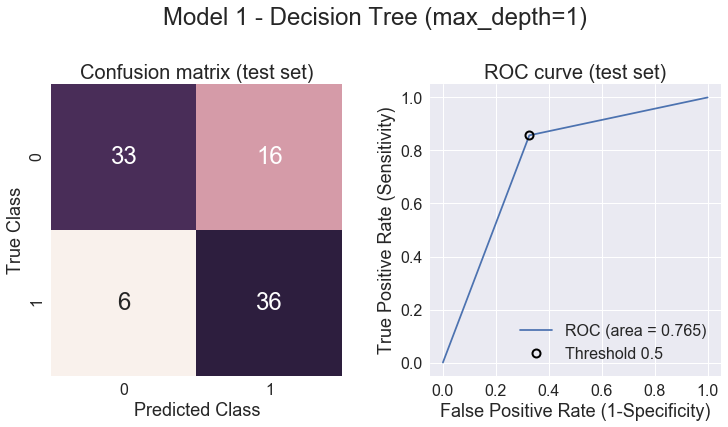

In [30]:
# Model 1: Decision Tree (max_depth=1, Underfitting)
model_num = 1
Tree1_name = "Decision Tree (max_depth=1)"

Tree1 = DecisionTreeClassifier(max_depth = 1, random_state = seed)

Tree1_metrics = evaluate_classifier(
        X_train = X_train, 
        X_test = X_test, 
        y_train = y_train, 
        y_test = y_test, 
        cv = kf,
        cv_scoring_method = cv_scoring_method,
        cv_scoring_name = cv_scoring_name,
        clf = Tree1,
        clf_name = Tree1_name,
        model_num = model_num,
        save_plots = save_plots)

The outputs from the custom-built `evaluate_classifier()` function for a decision tree of depth 1 is shown above.  At the training phase, the model gives an accuracy of 0.76.  To have a better idea of how well the model would generalize in unseen data, we performed 10-fold cross validation on the training set.  Having predicted classes from each fold, we can compute the scores in cross validation, which is a more realistic estimate of the model's performance.    

As we split the data into training and test sets earlier at the beginning in Step 2, we noticed that thare 42 cases with `presence`=1 (`True`) and 49 cases with `presence`=0 (`False`).  If we simply create a dummy classifier that always predicts a 0, it would have been right 54% of the time.  When we use a decision tree of depth 1, the accuracy score for the test set is around 0.76, which is better than the score produced by the dummy classifier, but still not that high. 

As described before, accuracy is not always the best measure to look at, especially when the classes are highly imbalanced.  Scores for other metrics are also presented in our outputs for illustration purposes.  These scores vary because they take into account different components of the confusion matrix.  We will put more attention to sensitivity, specificity and the area under the ROC curve (ROC_AUC) in the remaining of this exercise for heart disease classification. 

We suspect that using a decision tree with depth of 1 is too simple and it underfits the data.  We will see in the coming models of how we can improve a tree to make it generalize better, but first let us try to visualize this tree.  

#### Visualizing the fitted tree

Unlike in R or in SAS Enterprise Miner, visualization of a decision tree in Python relies on an external software.  One can export a fitted tree to a text file using the `export_graphviz()` function in the `tree` module in `scikit-learn`, then compile the text file to create an image.  Compilation of the image requires the Graphviz binary file, which is outside of Anaconda and is not available on Network A.  Alternatively, there are various web versions of Graphviz available on the internet.  On the web application, one can copy and paste the contents of the text file generated from `export_graphviz()`.  The tree image will then be displayed on screen and you can download and save the image file.  We loaded the image onto the Jupyter notebook for illustration:

<img src="Graphviz_images/Tree1.png">

This is the resulting image file generated from a Graphviz web application for Model 1, i.e., the tree fitted with the requirement `max_depth=1`.  At the root, there are 212 units, i.e., we start from the entire training set.  It contains 115 units in class 0 (absence of heart disease) and 97 units in class 1 (presence of heart disease).  The tree is split according to one condition: `chest_pain_type_4 <= 0.5`, which is equivalent to `chest_pain_type_4 = 0` or whether chest_pain_type is not 4 (asymptomatic).  When the condition is true, the unit goes to the leaf node on the left.  When the condition is false, the unit goes to the right node.  

- At the left node, there are 120 observations.  The class probabilties for Class 0 and Class 1 are $\left( \frac{92}{120}, \frac{28}{120} \right) = \left( 0.7667, 0.2333 \right)$.  
- At the right node, there are 92 observations.  The class probabilities for Class 0 and Class 1 are $\left( \frac{23}{92}, \frac{69}{92} \right) = \left( 0.25, 0.75 \right)$.

By default, the class probability threshold is 0.5, so all units in the left node are predicted as Class 0 and all units in the right node are predicted as Class 1.  In other words, based on this model, if a person shows no symptoms when he/she presents himself/herself at the clinic, this decision tree predicts that the person has heart disease.

We can also construct a confusion matrix among all units in the training set:
 - 92 Class 0 units are correctly predicted as Class 0 (True Negative)
 - 28 Class 1 untis are incorrectly predicted as Class 0 (False Negative)
 - 23 Class 0 units are incorrectly predicted as Class 1 (False Positive)
 - 69 Class 1 units are correctly predicted as Class 1 (True Positive)

Plugging these counts into various formulas we can obtain the training scores found in the "Evaluation on the training set" section of the results above.  Note that the same condition `chest_pain_type_4 <= 0.5` is being applied to the test data to obtain the predicted classes.

Another way to visualize a classification model is to write a program to plot the decision boundaries.  For decision trees, the plot allows you to visualize a leaf of a tree as a (hyper)rectangular region.  The entire tree would be just a (hyper)rectangular space being split into multiple mutually exclusive rectangular regions.  However, visualizing hyperplanes with more than two or three dimensions would be a problem if the fitted model involves more than two features.  For those who are interested in plotting the decision boundaries, please consult the examples on `scikit-learn's` website or in Raschka (2015).

### Model 2: Decision Tree (default)

Let's see what would happen if we do not specify any requirement for the tree.  We will construct a "default" decision tree object.  The `print` command will print all the parameter values being fed into the `DecisionTreeClassifier` constructor.  In particular, we see that there are no restrictions on the depth of the tree and on the number of leaf nodes.  Also, the Gini Impurity is used as a measure of the quality of the split.  As long as there are at least two units at a node, a split will be made if the threshold, governed by `min_impurity_split` (Note: it will be called `min_impurity_decrease` starting from `scikit-learn` version 0.19) is high enough.  The smallest number of samples allowed at a leaf node is one.    

In [31]:
# Model 2: Decision Tree (default parameters, Overfiting)
model_num += 1
Tree2_name = "Decision Tree (default)"

Tree2 = DecisionTreeClassifier(random_state = seed)

print(Tree2)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=274, splitter='best')




### ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ###
###  Model 2: Decision Tree (default)
### ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ###

-------------------------------
Evaluation on the training set:
-------------------------------

Accuracy: 1.000000
Precision: 1.000000
Recall: 1.000000
Sensitivity: 1.000000
Specificity: 1.000000
Matthews Correlation Coefficient: 1.000000
F1 score: 1.000000
Area under ROC: 1.000000

-----------------------------
10-Fold Cross Validation:
-----------------------------

Roc_Auc score:
        mean: 0.711729
         std: 0.112284

-----------------------------
Evaluation on the test set:
-----------------------------

Accuracy: 0.703297
Precision: 0.674419
Recall: 0.690476
Sensitivity: 0.690476
Specificity: 0.714286
Matthews Correlation Coefficient: 0.404173
F1 score: 0.682353
Area under ROC: 0.702381


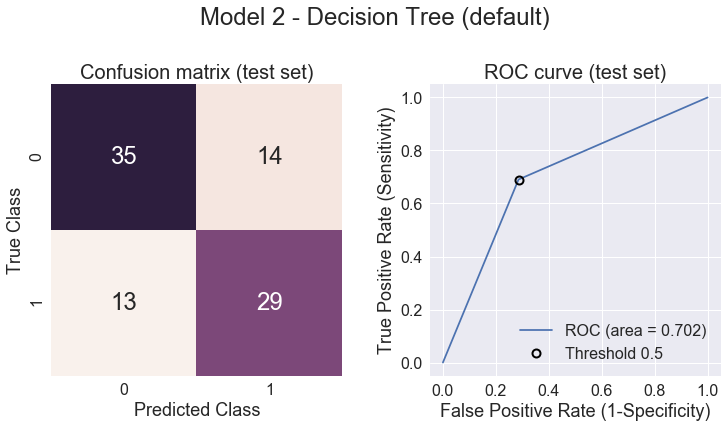

In [32]:
Tree2_metrics = evaluate_classifier(
        X_train = X_train, 
        X_test = X_test, 
        y_train = y_train, 
        y_test = y_test, 
        cv = kf,
        cv_scoring_method = cv_scoring_method,
        cv_scoring_name = cv_scoring_name,
        clf = Tree2,
        clf_name = Tree2_name,
        model_num = model_num,
        save_plots = save_plots)

With almost no constraints in the tree, we would probably expect the algorithm to find a tree that fits the data really well.  However, what we meant by "data" only refers to the training set, as the algorithm has no access to any test data during training.  The fitted tree turns out to be too specific to the training data, and does not generalize well in the test set.  We can tell from the scores that overfitting did occur.  Having training scores of 1 means that the model fits perfectly on the training data, i.e., all units are classified correctly.  The average score from cross validation, on the other hand, does not show much improvement compared to that in Model 1.  In terms of prediction peformance on the test set, there is a higher number of false negatives compared to Model 1, which results in lower sensitivity.  It means that the decision paths that give a prediction of class 0 does not work well for the test data.

A Graphviz image of the tree is provided below for visualization purposes.  Compared to the tree from Model 1, this tree is much more complex.  It has a total of 36 leaf nodes and is 10 levels deep for some portions of the tree.  The Gini Impurity for all 36 leaf nodes are 0, and some of the leaves only contain one observation.

<img src="Graphviz_images/Tree2.png">

### Model 3: Decision Tree (grid search)

In Model 1, we see that using a too simple model underfits the data.  In contrast, in Model 2, we find that using an overly complex tree overfits the data.  How can we find the balance?  Techniques such as pruning would help.  Starting from a fully grown complex tree, pruning collapses the tree, aiming at reducing the depth and the number of nodes in an overfitted tree without losing too much accuracy.  Unfortunately, pruning is currently not supported in the `scikit-learn` package.  What we could do instead, is to try to find, via a grid search (`GridSearchCV()`) or a randomized search(`RandomizedSearchCV()`), an optimal set of hyperparameters that would give a tree that performs relatively well in both the training set and test set.

In this example, we will try to tune the `max_depth` hyperparameter.  We set up a grid of possible values (1 to 10), and pass that into the `GridSearchCV()` function.  For each possible hyperparameter value, it will fit a tree using 10-fold cross validation.  The training and validation scores are recorded for each of the 10 cross validation runs and for each of the 10 possible values.  Since we are only tuning one hyperparameter, we can plot the average training and validation scores (along with their corresponding standard deviation) for each possible value of `max_depth`.  This type of plot is called validation curves.  Our goal is to find an optimal value of the `max_depth` hyperparameter such that it gives the best score in cross validation.



### ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ###
###  Model 3: Decision Tree (grid search)
### ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ###

-------------------------------
Evaluation on the training set:
-------------------------------

Accuracy: 0.863208
Precision: 0.914634
Recall: 0.773196
Sensitivity: 0.773196
Specificity: 0.939130
Matthews Correlation Coefficient: 0.728677
F1 score: 0.837989
Area under ROC: 0.908875

--------------------------------------------------
(Cross validation, grid search) Average F1 score:
--------------------------------------------------


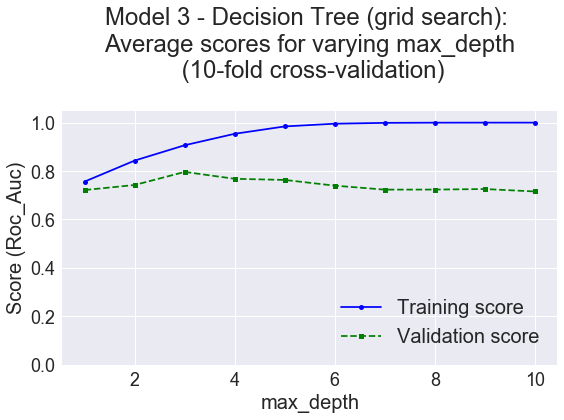

mean=0.721626, std=0.082029, {'max_depth': 1}
mean=0.742518, std=0.127534, {'max_depth': 2}
mean=0.796516, std=0.103006, {'max_depth': 3}
mean=0.768001, std=0.152272, {'max_depth': 4}
mean=0.763368, std=0.158427, {'max_depth': 5}
mean=0.739758, std=0.137216, {'max_depth': 6}
mean=0.723302, std=0.134450, {'max_depth': 7}
mean=0.723561, std=0.124946, {'max_depth': 8}
mean=0.725795, std=0.096035, {'max_depth': 9}
mean=0.715706, std=0.106058, {'max_depth': 10}

The top 5 models are as follows:
Model with rank: 1
Mean validation score: 0.796516 (std: 0.103006)
Parameters: {'max_depth': 3}

Model with rank: 2
Mean validation score: 0.768001 (std: 0.152272)
Parameters: {'max_depth': 4}

Model with rank: 3
Mean validation score: 0.763368 (std: 0.158427)
Parameters: {'max_depth': 5}

Model with rank: 4
Mean validation score: 0.742518 (std: 0.127534)
Parameters: {'max_depth': 2}

Model with rank: 5
Mean validation score: 0.739758 (std: 0.137216)
Parameters: {'max_depth': 6}


best_params_:
{'max

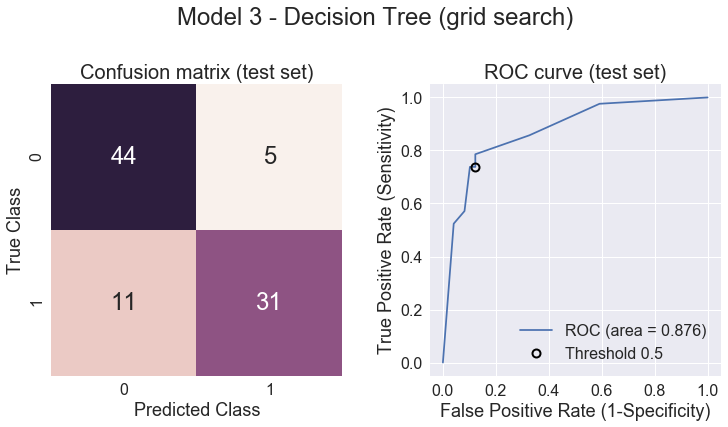

In [33]:
# Model 3: Decision Tree (hyperparameter = max_depth)
# By default, GridSearchCV trains the best model found with the entire training set 
model_num += 1
Tree_gs_name = "Decision Tree (grid search)"

Tree3 = DecisionTreeClassifier(random_state = seed)
DT_parameter_grid = [
    { 'max_depth':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
    ]

Tree_gs = GridSearchCV(
            estimator = Tree3,
            param_grid = DT_parameter_grid,
            scoring = cv_scoring_method,
            cv = kf,
            n_jobs = 1)

Tree_gs_metrics = evaluate_grid_classifier(
        X_train = X_train,
        X_test = X_test,
        y_train = y_train,
        y_test = y_test,
        cv_scoring_method = cv_scoring_method,
        cv_scoring_name = cv_scoring_name,
        clf = Tree_gs,
        clf_name = Tree_gs_name,
        model_num = model_num,
        plot_valid_curve = True,
        save_plots = save_plots)


On the validation curve, the training scores go up gradually and become 1 as it reaches 6 or more levels deep.  On the other hand, the validation scores increase slightly at the beginning, then reach a maximum at max_depth of 3.  After that, they start to decrease as the tree becomes more complex.  We can tell that the model underfits at the beginning, with the low training and low validation scores, and it overfits when the tree gets too deep, with high training scores but low validation scores.  From these results, max_depth=3 gives the best generalization performance in the validation set.

Once we have found the optimal hyperparmater value, we trained the data using the full training set.  We applied the fitted model with the test set.  While there are still a high number of false negatives in the test set, the number of false positives have greatly reduced.  Specificity in this model reaches almost 0.9 for the test set.

Below is a visual representation of the optimized tree, with `max_depth`=3:

<img src="Graphviz_images/Tree3.png">

The hyperparamter value `max_depth`=3 gives a tree with good cross validation scores.  This does not mean that this is the best tree you can get.  Besides `max_depth`, there are other hyperparameters in the decision tree.  You can run a grid search to look for optimal values for a combination of hyperparamters.  We will present an example later when we discuss random forests.

### Model 4: Bagging (max_depth=3) (grid search)

Instead of using only a single tree, we could use a collection of trees to improve the predictive performance and to reduce the variance.  Bootstrap Aggregation, commonly known as Bagging, is an ensemble method that uses bootstrap samples to fit a collection of decision trees.  The Bagging algorithm works as follows: From the training set, we randomly select, with replacement, a bootstrap sample size of n. Then we train the classifier or the regression model on the bootstrapped sample.  We repeat this B times.  The final fitted model is the average prediction from each regression model, or, in classification, it is the resulting majority vote over the B classifiers. 

In Python, the `BaggingClassifier` object contains a `base_estimator`, which by default is a fully grown decision tree.  Decision trees are good candidates for bagging because a slight perturbation in the training set can give a different tree.  Another possible candidate for bagging would be neural networks.

Let's perform a grid search to see what happens when the number of bagged trees increases from 1 to 150.  For illustration purposes, we use trees with `max_depth`=3.

In [34]:
# Model 4: Bagging (max_depth=3) (with hyperparameter tuning)
model_num += 1
Bag_gs_name = "Bagging (grid search)"

BTree = DecisionTreeClassifier(max_depth=3)
Bag = BaggingClassifier(base_estimator = BTree,
                         random_state = seed)

print(Bag)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=10, n_jobs=1, oob_score=False,
         random_state=274, verbose=0, warm_start=False)




### ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ###
###  Model 4: Bagging (grid search)
### ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ###

-------------------------------
Evaluation on the training set:
-------------------------------

Accuracy: 0.915094
Precision: 0.943820
Recall: 0.865979
Sensitivity: 0.865979
Specificity: 0.956522
Matthews Correlation Coefficient: 0.830278
F1 score: 0.903226
Area under ROC: 0.962618

--------------------------------------------------
(Cross validation, grid search) Average F1 score:
--------------------------------------------------


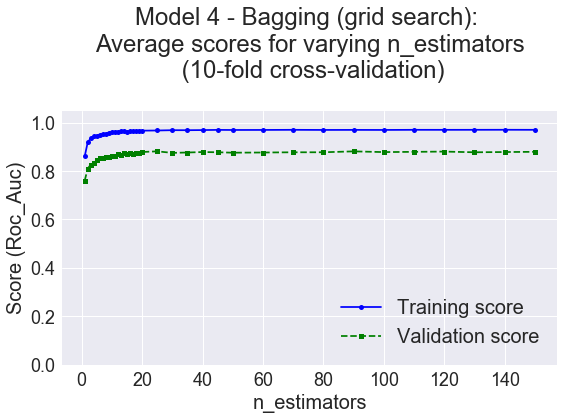

mean=0.760374, std=0.060502, {'n_estimators': 1}
mean=0.810339, std=0.077119, {'n_estimators': 2}
mean=0.826813, std=0.063344, {'n_estimators': 3}
mean=0.832764, std=0.063935, {'n_estimators': 4}
mean=0.845013, std=0.062547, {'n_estimators': 5}
mean=0.853148, std=0.063281, {'n_estimators': 6}
mean=0.853683, std=0.069583, {'n_estimators': 7}
mean=0.857581, std=0.068681, {'n_estimators': 8}
mean=0.859234, std=0.075494, {'n_estimators': 9}
mean=0.860532, std=0.070563, {'n_estimators': 10}
mean=0.863288, std=0.072588, {'n_estimators': 11}
mean=0.872213, std=0.068609, {'n_estimators': 12}
mean=0.867565, std=0.073122, {'n_estimators': 13}
mean=0.874877, std=0.066428, {'n_estimators': 14}
mean=0.870893, std=0.073050, {'n_estimators': 15}
mean=0.876029, std=0.066704, {'n_estimators': 16}
mean=0.870228, std=0.068729, {'n_estimators': 17}
mean=0.873832, std=0.075240, {'n_estimators': 18}
mean=0.876033, std=0.073717, {'n_estimators': 19}
mean=0.878715, std=0.071474, {'n_estimators': 20}
mean=0.88

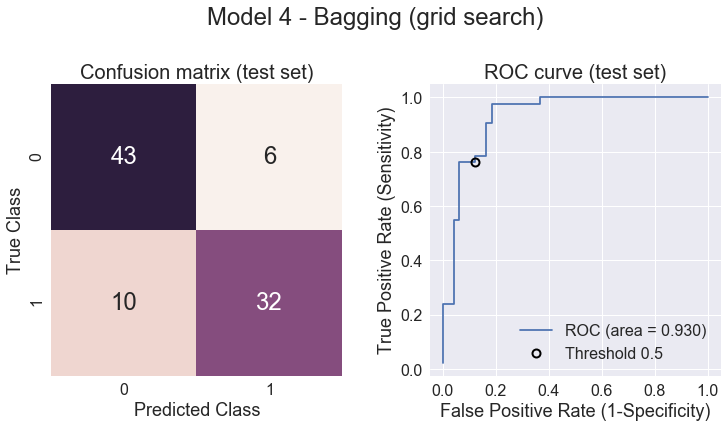

In [35]:
Bag_parameter_grid = [
    { 'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 
                       11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 
                       25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100, 
                       110, 120, 130, 140, 150] }
    ]

Bag_gs = GridSearchCV(
            estimator = Bag,
            param_grid = Bag_parameter_grid,
            scoring = cv_scoring_method,
            cv = kf)

Bag_gs_metrics = evaluate_grid_classifier(
        X_train = X_train,
        X_test = X_test,
        y_train = y_train,
        y_test = y_test,
        cv_scoring_method = cv_scoring_method,
        cv_scoring_name = cv_scoring_name,
        clf = Bag_gs,
        clf_name = Bag_gs_name,
        model_num = model_num,
        plot_valid_curve = True,
        save_plots = save_plots)

With only one tree, its performance is similar to a decision tree.  As we add more trees, both the training and validation scores increase. The training scores reach a plateau after about 20 trees.  As for validation scores, they fluctuate very slightly and attain a maximum at 25 trees, but there is not really much difference after.  

Note that we are using trees with max_depth of 3 for demonstration purposes, which could possibly make the trees more correlated to each other, and so we did not need so many trees.

In terms of predictive performance on the test set, bagging is slightly better than a single decision tree with optimal `max_depth` (Model 3).

### Model 5: Random Forest (grid search)

We've seen in Bagging that the trees are correlated to each other.  Even though bootstrap samples are selected, the splits considered are still similar because there are often a few predictors that dominate the tree fitting process.  In Random Forests, an extra layer of randomness is introduced to make the trees less correlated: at each split, only a random subset of features is considered.  This randomness ensures that important features are not guaranteed to be considered at a split, thus making the trees less similar to each other.  Having such de-correlated trees in a bag can reduce the variance.  For classification problems, typical choice for the number of features considered is  $ \sqrt{p} $, which is the square root of the number of features being considered in the `X` matrix.

We will create a `RandomForestClassifier` object to fit our Heart Disease data. 

In [36]:
# Model 5: Random Forest (with hyperparameter tuning)
# Default parameter: max_features = "sqrt"
# Hyperparameters: n_estimators, max_depth
model_num += 1
Forest_gs_name = "Random Forest (grid search)"
Forest = RandomForestClassifier(random_state = seed)
print(Forest)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=274,
            verbose=0, warm_start=False)


By default, the trees are fully grown and are not pruned.  Here, we will do a more extensive grid search and include tree depth as a hyperparameter as well.  Since we have some dummy variables in the data, perhaps we need to increase the number of features for each split.



### ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ###
###  Model 5: Random Forest (grid search)
### ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ###

-------------------------------
Evaluation on the training set:
-------------------------------

Accuracy: 0.886792
Precision: 0.919540
Recall: 0.824742
Sensitivity: 0.824742
Specificity: 0.939130
Matthews Correlation Coefficient: 0.773644
F1 score: 0.869565
Area under ROC: 0.952846

--------------------------------------------------
(Cross validation, grid search) Average F1 score:
--------------------------------------------------
mean=0.745297, std=0.129097, {'max_features': 4, 'n_estimators': 1, 'max_depth': 3}
mean=0.808953, std=0.110218, {'max_features': 4, 'n_estimators': 2, 'max_depth': 3}
mean=0.848491, std=0.090247, {'max_features': 4, 'n_estimators': 3, 'max_depth': 3}
mean=0.872299, std=0.058507, {'max_features': 4, 'n_estimators': 4, 'max_depth': 3}
mean=0.876996, std=0.0

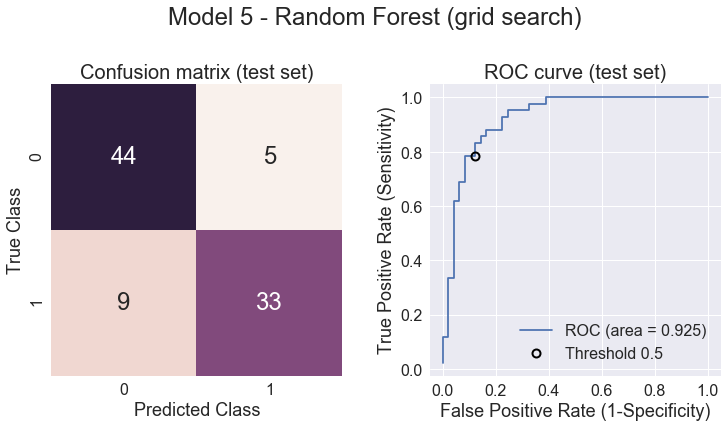


feature_importances_:
(0.18522154002944097, 'chest_pain_type_4')
(0.18358650022166631, 'thal_7')
(0.1198027272366859, 'max_hr_achieved')
(0.11415758625522411, 'coloured_vessels')
(0.10152140106175715, 'old_peak')
(0.071716603617638361, 'exer_induced_angina')
(0.050614570485784591, 'slope_2')
(0.046242213579421425, 'age')
(0.027534927919524554, 'sex')
(0.023980249760881134, 'rest_bp')
(0.022868308865714497, 'chest_pain_type_3')
(0.021585526734117181, 'cholesterol')
(0.0095829261974516456, 'chest_pain_type_2')
(0.009015980096223156, 'rest_ecg_2')
(0.0053349198116551194, 'fast_blood_sugar')
(0.0047917221360526587, 'slope_3')
(0.0022523938262979893, 'thal_6')
(0.00018990216446329982, 'rest_ecg_1')


In [37]:
Forest_parameter_grid = [
    { 'n_estimators':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 
                      15, 20, 25, 50, 75, 100, 
                      125, 150, 175, 200, 225, 250],
      'max_depth':[3, 4, 5, None],
      'max_features':[4, 5, 6]}
    ]

Forest_gs = GridSearchCV(
            estimator = Forest,
            param_grid = Forest_parameter_grid,
            scoring = cv_scoring_method,
            cv = kf)
 
Forest_gs_metrics = evaluate_grid_classifier(
        X_train = X_train,
        X_test = X_test,
        y_train = y_train,
        y_test = y_test,
        cv_scoring_method = cv_scoring_method,
        cv_scoring_name = cv_scoring_name,
        clf = Forest_gs,
        clf_name = Forest_gs_name,
        model_num = model_num,
        print_feat_impt = True,
        save_plots = save_plots)

The combination of hyperparameters that gave the top 5 validation scores are presented here.  In this example, we would still prefer to use 4 features ($\sqrt{p}$, with $p$=18) at each split, and compared to bagging, we would need more trees.  Note that in the original Random Forest paper in Breiman (2001), the trees are fully grown and are not pruned.  In our case, we did try with a fully grown tree (`max_depth`=None), but we got a slightly lower score in cross validation.

In terms of predictive performance on the test set, the optimal random forest model is slightly better than a single decision tree with optimal `max_depth` (Model 3).

One of the attributes of the random forest classifier is `feature_importances_`, which are the relative importance of each feature among all features being considered in the `X` matrix.  In this example, we see that chest_pain_type=4 and thal=7 are the most discriminative feature in the dataset based on the average impurity decrease.  However, it is important to note that these feature importances are not meant to be interpreted in a way similar to regression coefficients.  These feature importances merely tell us the predictive performance of each feature rather than the relationship among the features.  When two features are highly correlated, it is likely that one feature is ranked highly while the information of the other feature may not be fully captured.

One can use random forest as a feature selection tool in an intermediate step of a pre-preprocessing pipeline.  We could set a threshold to the `transform()` function in the random forest classifier so that only the most important features will be considered.

### Model 6: AdaBoost (grid search)

Besides bagging and random forests, boosting is another ensemble method.  In boosting, a first model is built from the training data, then the second model is created aiming at correcting the errors from the first model.  Models are added to the ensemble until the training set is predicted perfectly, or until a pre-specified number of models have been built.  Adaptive Boosting (Freund and Schapire, 1997), commonly know as AdaBoost, is one of the boosting algorithms.

While AdaBoost can be used to enhance the performance of any machine learning algorithm, it is best used with weak learners, so decision trees with a depth of 1 (decision stumps) are a common choice.  In AdaBoost, training data that were predicted incorrectly using the current model are given higher weights for the subsequent model.  Even though decision stumps have high bias if being used alone, by adjusting the weights at each subsequent model, bias can be reduced.  As the $k^{th}$ tree learned from the previous k-1 trees, predictions will get closer and closer to the true value.

We will use AdaBoost algorithm to train our Heart Disease data set.  By default, the base estimator, if left unspecified, is set as a decision stump.  Here, we specify it explicitly to be decision trees of depth 1, which still represents decision stumps.  The hyperparameters for AdaBoost are `n_estimators` and `learning_rate`.  The learning rate governs the shrinkage speed of the contribution of each classifer.  There is a trade-off between these two hyperparameters. 

Let us fix the learning rate and see what happens as we increase the number of decision stumps (`n_estimators`) from 1 to 250.



### ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ###
###  Model 6: AdaBoost (grid search)
### ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ###

-------------------------------
Evaluation on the training set:
-------------------------------

Accuracy: 0.886792
Precision: 0.910112
Recall: 0.835052
Sensitivity: 0.835052
Specificity: 0.930435
Matthews Correlation Coefficient: 0.772724
F1 score: 0.870968
Area under ROC: 0.968086

--------------------------------------------------
(Cross validation, grid search) Average F1 score:
--------------------------------------------------


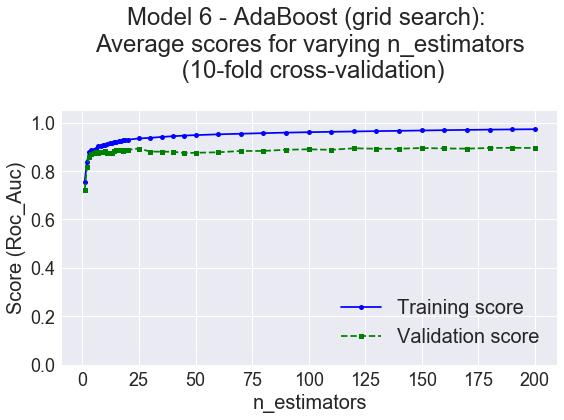

mean=0.721626, std=0.082029, {'n_estimators': 1}
mean=0.817032, std=0.092629, {'n_estimators': 2}
mean=0.859911, std=0.101188, {'n_estimators': 3}
mean=0.870074, std=0.080248, {'n_estimators': 4}
mean=0.874612, std=0.082555, {'n_estimators': 5}
mean=0.877347, std=0.080303, {'n_estimators': 6}
mean=0.874462, std=0.074373, {'n_estimators': 7}
mean=0.877247, std=0.068963, {'n_estimators': 8}
mean=0.876701, std=0.066851, {'n_estimators': 9}
mean=0.882321, std=0.068955, {'n_estimators': 10}
mean=0.875846, std=0.068356, {'n_estimators': 11}
mean=0.875810, std=0.071740, {'n_estimators': 12}
mean=0.876093, std=0.070646, {'n_estimators': 13}
mean=0.881207, std=0.070104, {'n_estimators': 14}
mean=0.885726, std=0.072221, {'n_estimators': 15}
mean=0.888609, std=0.067896, {'n_estimators': 16}
mean=0.887161, std=0.063071, {'n_estimators': 17}
mean=0.882853, std=0.059187, {'n_estimators': 18}
mean=0.886626, std=0.055334, {'n_estimators': 19}
mean=0.887591, std=0.057907, {'n_estimators': 20}
mean=0.89

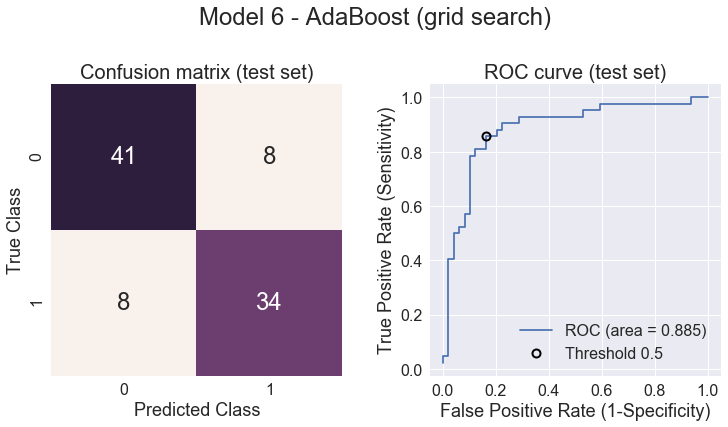

In [38]:
# Model 6: AdaBoost (grid search)
# Base classifier: Decision Tree of depth 1 (desicion stumps)
model_num += 1
Boost_gs_name = "AdaBoost (grid search)"

ABTree = DecisionTreeClassifier(max_depth = 1)

Boost = AdaBoostClassifier(base_estimator = ABTree,
                            learning_rate = 0.12, 
                            random_state = seed)

Boost_parameter_grid = [
    { 'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 
                       11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 
                       25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100, 
                       110, 120, 130, 140, 150, 160, 170, 180, 190, 200] }
    ]

Boost_gs = GridSearchCV(
            estimator = Boost,
            param_grid = Boost_parameter_grid,
            scoring = cv_scoring_method,
            cv = kf)

Boost_gs_metrics = evaluate_grid_classifier(
        X_train = X_train,
        X_test = X_test,
        y_train = y_train,
        y_test = y_test,
        cv_scoring_method = cv_scoring_method,
        cv_scoring_name = cv_scoring_name,
        clf = Boost_gs,
        clf_name = Boost_gs_name,
        model_num = model_num,
        plot_valid_curve = True,
        save_plots = save_plots)


The above code is just an illustration of how we can use a collection of decision stumps in AdaBoost.  With this particular learning rate, we would need 190 trees to get an optimal validation score.  You can modify the program to find an optimal pair of `learning_rate` and `n_estimators`.  You could also try with a slightly deeper tree (e.g. `max_depth`=2); however, fully grown trees are not recommended since AdaBoost is designed to work well with classifiers that have high bias, which for trees it usually means shallow trees.

## Step 4: Comparison of the predictive performance of each model on the test set

For each of the models we ran above, we saved the scores in an array.  The first component of the array (`<model>_metrics[0]`) is the training scores, the second component (`<model>_metrics[1]`) is the validation scores, and the third component (`<model>_metrics[2]`) is the test scores.

We can then pull all the scores together and present them in a table.  We can also plot all the ROC curves on the test set.  These are programmed within the `model_comparisons` function in `HD_model_comparisons.py`.

In [39]:
from HD_model_comparisons import model_comparisons


### ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ###
###  Final comparisons
### ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ###

-------------------------------
Evaluation on the training set:
-------------------------------
                         model   roc_auc  accuracy precision    recall  \
0       AdaBoost (grid search)  0.968086  0.886792  0.910112  0.835052   
1        Bagging (grid search)  0.962618  0.915094   0.94382  0.865979   
2      Decision Tree (default)         1         1         1         1   
3  Decision Tree (grid search)  0.908875  0.863208  0.914634  0.773196   
4  Decision Tree (max_depth=1)   0.75567  0.759434      0.75   0.71134   
5  Random Forest (grid search)  0.952846  0.886792   0.91954  0.824742   

  sensitivity specificity        f1       MCC      confusion_matrix  \
0    0.835052    0.930435  0.870968  0.772724  [[107, 8], [16, 81]]   
1    0.865979    0.956522  0.903226  0.830278  [[110, 5], 

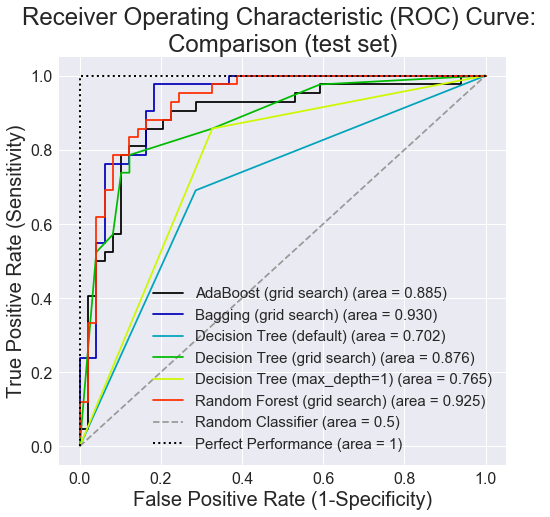

In [40]:
# Metrics for the training set
metrics_train = {
        Tree1_name : Tree1_metrics[0],
        Tree2_name : Tree2_metrics[0],
        Tree_gs_name : Tree_gs_metrics[0],
        Bag_gs_name : Bag_gs_metrics[0],
        Forest_gs_name : Forest_gs_metrics[0],
        Boost_gs_name : Boost_gs_metrics[0]
        }

# Metrics for the test set
metrics_cv = {
        Tree1_name : Tree1_metrics[1],
        Tree2_name : Tree2_metrics[1],
        Tree_gs_name : Tree_gs_metrics[1],
        Bag_gs_name : Bag_gs_metrics[1],
        Forest_gs_name : Forest_gs_metrics[1],
        Boost_gs_name : Boost_gs_metrics[1]
        }


# Metrics for the test set
metrics_test = {
        Tree1_name : Tree1_metrics[2],
        Tree2_name : Tree2_metrics[2],
        Tree_gs_name : Tree_gs_metrics[2],
        Bag_gs_name : Bag_gs_metrics[2],
        Forest_gs_name : Forest_gs_metrics[2],
        Boost_gs_name : Boost_gs_metrics[2]
        }

# Display the metrics ROC curves
metrics_train_df, metrics_cv_df, metrics_test_df = model_comparisons(metrics_train, 
                                                                     metrics_cv,
                                                                     metrics_test,
                                                                     cv_scoring_name,
                                                                     save_plots = save_plots)

In the tables above, the training scores are obtained for a specified model (Models 1 & 2) or after the best model is chosen and retrained on the entire training set (Models 3, 4, 5 & 6).  The validation scores are the average score from 10-fold cross valdiation, for the specified model or for the best model found from hyperparameter tuning.  The combination of training and validation scores tell us whether the model is overfitting or underfitting.

At this stage we are interested in comparing the models' performance on the test set.  
- In terms of sensitivity, the three ensemble methods (Bagging, Random Forest and AdaBoost) show better scores than a single decision tree.
- In terms of specificity, Bagging, Random Forest and an optimal Decision Tree show high scores than AdaBoost.

From the ROC curves, we see that:
- All the six models considered are far from the diagonal line.  These methods are clearly better than a random classifier.
- Decision Trees Model 1 (`max_depth`=1) and Model 2 (default) give the smallest area under the ROC curve.  Compared to all other models, they are relatively closer to the diagonal line.  Decision Tree Model 3 (grid search) is further away from Models 1 and 2, but its area is still smaller than that for the ensemble methods.
- Among the ensemble methods, Bagging (Model 4) and Random Forest (Model 6) give the best area under the ROC curve.

The pair of sensitivity and (1-specificity) scores only represents one point on the ROC curve.  It is possible to adjust the thresholds and move along the ROC curve during training and model selection phase in order to achieve better sensitivity or better specifcity, but not both at the same time.

With these final results, we could export the training, validation and test scores to an Excel file.  We will not run it in this notebook, but here is the code (in comments):

In [41]:
## Save the metrics into an Excel file

#Excel_out = "HD_model_comparisons_Presentation.xlsx"

#writer = pd.ExcelWriter(Excel_out)
#metrics_train_df.to_excel(writer, "Training set", index=False)
#metrics_cv_df.to_excel(writer, "Cross validation", index=False)
#metrics_test_df.to_excel(writer, "Test set", index=False)
#writer.save()

## Concluding Remarks

What we presented in this example is just for illustration purposes.  Apart from using tree-based methods, we could try with many different machine learning algorithms.

We could always look into ways to improve the predictions.  For example, we could improve data processing by doing feature selection or extraction, or treating outliers.  We could even create bins for some numeric variables such as age.  During training, we could use a more extensive list of hyperparameters, or use another cross validation method.  Instead of tree depth, we could try other hyperparameters that control the splits or the size of the leaves.

There are also other options such as fine tuning the class probability thresholds, or to use a more appropriate metric for evaluation of performance.  We should be aware that an extremely high validation score could mean that the metric used is not the best choice.  You could look at more than one metric during cross validation in the new version of scikit-learn (0.19), although Anaconda 4.4 (installed on Network A) does not have this latest version yet.

We hope you find this example useful and that it could get you started in your learning process.  Please feel free to adapt parts of our pipeline to suit your machine learning projects. 

If you would like to run this pipeline from the command prompt, please follow the instructions in `README.txt`. 

The list of references cited in this notebook can be found in the "Learning material" section in `README.txt`. 